In [65]:
# Disable warinings
import os; os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'; os.environ['KMP_DUPLICATE_LIB_OK']='True' 

#DNN library
import tensorflow as tf
import keras, sklearn
from keras.models import Sequential
from keras.layers import Dense, Dropout

#common library
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib as mpl
mpl.rc('image', cmap='copper') #global colormap 

#random seed
seed=2086516
np.random.seed(seed) # fix random seed

%run nonlinear_function.py #here is loaded the filename, run one i belive

#training percentage
perc_train = 0.8

In [16]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

2
[-31.60811883 -29.54397214] 0.0
[6.77250291 9.5544703 ] 1.0
[46.45145197 15.31770969] 1.0
[24.89066375 15.35698709] 0.0
[24.77148093 46.13067361] 1.0
[-49.16117021 -39.35556233] 0.0
[-20.12962862  15.64111831] 1.0
[30.98125525 37.21759137] 1.0
[46.46475974 22.36853469] 1.0
[14.24753279 21.74536208] 0.0
data: 4000
train: 3200


<function matplotlib.pyplot.show(close=None, block=None)>

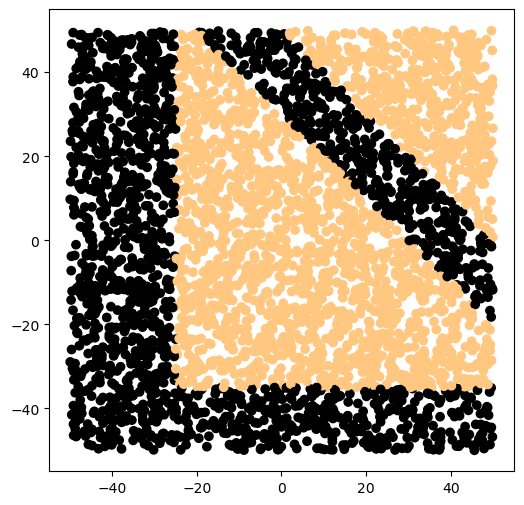

In [17]:
# Keras works with numpy arrays: just use them from the start
TYPE=1
x = np.loadtxt(filename("data",TYPE), delimiter=' ')
y = np.loadtxt(filename("labels",TYPE), delimiter=' ')
N = len(x)

# dim. of a sample
L = len(x[0])
print(L)

for i in range(10):
    print(x[i],y[i])

N_train = int(perc_train * N)
print(f'data: {N}\ntrain: {N_train}')

plt.figure(figsize = (6,6))
plt.scatter(x[:,0],x[:,1],c=y)
plt.show

In [18]:
### Split training and test data

(x_train, y_train) = (x[0:N_train],y[0:N_train]) #they are already shuffle 
(x_valid, y_valid) = (x[N_train:],y[N_train:])
print("Train:",len(x_train),"\t Validation:",len(x_valid))

Train: 3200 	 Validation: 800


In [19]:
### Rescale input data

def Rescale(x):
    #return (x-x.mean())/np.sqrt(x.var())
    return x/50 #the number goes from -50 to 50, so we put them between -1 and 1 to use the non linearity 

x_train = Rescale(x_train)
x_valid = Rescale(x_valid)

### Define the model with Keras / Tensorflow

In [29]:
def create_DNN(act_func): 
    CASE=1
    
    if CASE==1:
        model = Sequential() #empty template of the neural network
        model.add(Dense(L,input_shape=(L,),activation=act_func)) #add a layer dense (all connection) with a ReLu 2 neuron for 2 x_i
        model.add(Dense(20,activation=act_func))
        model.add(Dense(20,activation=act_func))
        model.add(Dense(20,activation=act_func))
        model.add(Dropout(0.2)) #it is applied to the last layer, need to be reader in keras documentation 
        model.add(Dense(1,activation='sigmoid'))
        nepoch=400
    # as case 1 but one layer shorter
    if CASE==2:
        model = Sequential()
        model.add(Dense(L,input_shape=(L,),activation=act_func))
        model.add(Dense(20,activation=act_func))
        model.add(Dense(20,activation=act_func))
        model.add(Dropout(0.2))
        model.add(Dense(1,activation='sigmoid'))
        nepoch=400
    
    return model 

### Optimization method and cost function

In [30]:
def compile_model(optimizer='adam', act_func='relu'):
    model = create_DNN(act_func)
    model.compile(loss='binary_crossentropy',
                  optimizer=optimizer,
                  metrics=['accuracy'])    
    return model

### Training

In [36]:
##%%timeit -r 2 -n 2
nepochs=400
batch_size=50

model_DNN = compile_model()

history = model_DNN.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=nepochs,
          verbose=1,
          validation_data=(x_valid, y_valid))

Epoch 1/400
64/64 [==============================] - 2s 9ms/step - loss: 0.6817 - accuracy: 0.5928 - val_loss: 0.6634 - val_accuracy: 0.6800
Epoch 2/400
64/64 [==============================] - 0s 7ms/step - loss: 0.6483 - accuracy: 0.6509 - val_loss: 0.6200 - val_accuracy: 0.6475
Epoch 3/400
64/64 [==============================] - 0s 7ms/step - loss: 0.6200 - accuracy: 0.6594 - val_loss: 0.5978 - val_accuracy: 0.6725
Epoch 4/400
64/64 [==============================] - 1s 8ms/step - loss: 0.5975 - accuracy: 0.6891 - val_loss: 0.5781 - val_accuracy: 0.6938
Epoch 5/400
64/64 [==============================] - 1s 9ms/step - loss: 0.5805 - accuracy: 0.7069 - val_loss: 0.5581 - val_accuracy: 0.7325
Epoch 6/400
64/64 [==============================] - 0s 7ms/step - loss: 0.5532 - accuracy: 0.7356 - val_loss: 0.5324 - val_accuracy: 0.7487
Epoch 7/400
64/64 [==============================] - 1s 9ms/step - loss: 0.5254 - accuracy: 0.7525 - val_loss: 0.5134 - val_accuracy: 0.7600
Epoch 8/400
6

Epoch 59/400
64/64 [==============================] - 0s 7ms/step - loss: 0.1470 - accuracy: 0.9494 - val_loss: 0.1297 - val_accuracy: 0.9638
Epoch 60/400
64/64 [==============================] - 0s 7ms/step - loss: 0.1526 - accuracy: 0.9453 - val_loss: 0.1229 - val_accuracy: 0.9675
Epoch 61/400
64/64 [==============================] - 0s 7ms/step - loss: 0.1434 - accuracy: 0.9497 - val_loss: 0.1170 - val_accuracy: 0.9775
Epoch 62/400
64/64 [==============================] - 0s 7ms/step - loss: 0.1414 - accuracy: 0.9544 - val_loss: 0.1251 - val_accuracy: 0.9613
Epoch 63/400
64/64 [==============================] - 1s 8ms/step - loss: 0.1453 - accuracy: 0.9484 - val_loss: 0.1189 - val_accuracy: 0.9575
Epoch 64/400
64/64 [==============================] - 0s 7ms/step - loss: 0.1391 - accuracy: 0.9475 - val_loss: 0.1170 - val_accuracy: 0.9663
Epoch 65/400
64/64 [==============================] - 1s 8ms/step - loss: 0.1389 - accuracy: 0.9506 - val_loss: 0.1178 - val_accuracy: 0.9675
Epoch 

64/64 [==============================] - 0s 7ms/step - loss: 0.1027 - accuracy: 0.9644 - val_loss: 0.1032 - val_accuracy: 0.9600
Epoch 117/400
64/64 [==============================] - 0s 8ms/step - loss: 0.0980 - accuracy: 0.9613 - val_loss: 0.0869 - val_accuracy: 0.9712
Epoch 118/400
64/64 [==============================] - 0s 8ms/step - loss: 0.0954 - accuracy: 0.9675 - val_loss: 0.1138 - val_accuracy: 0.9550
Epoch 119/400
64/64 [==============================] - 0s 7ms/step - loss: 0.0941 - accuracy: 0.9684 - val_loss: 0.0723 - val_accuracy: 0.9837
Epoch 120/400
64/64 [==============================] - 0s 8ms/step - loss: 0.1085 - accuracy: 0.9628 - val_loss: 0.0934 - val_accuracy: 0.9725
Epoch 121/400
64/64 [==============================] - 0s 6ms/step - loss: 0.0974 - accuracy: 0.9628 - val_loss: 0.0713 - val_accuracy: 0.9800
Epoch 122/400
64/64 [==============================] - 0s 7ms/step - loss: 0.0874 - accuracy: 0.9712 - val_loss: 0.0760 - val_accuracy: 0.9787
Epoch 123/400

64/64 [==============================] - 1s 8ms/step - loss: 0.0819 - accuracy: 0.9700 - val_loss: 0.0540 - val_accuracy: 0.9812
Epoch 174/400
64/64 [==============================] - 0s 7ms/step - loss: 0.0793 - accuracy: 0.9697 - val_loss: 0.0685 - val_accuracy: 0.9762
Epoch 175/400
64/64 [==============================] - 0s 7ms/step - loss: 0.0760 - accuracy: 0.9716 - val_loss: 0.1093 - val_accuracy: 0.9513
Epoch 176/400
64/64 [==============================] - 0s 7ms/step - loss: 0.0829 - accuracy: 0.9722 - val_loss: 0.0841 - val_accuracy: 0.9725
Epoch 177/400
64/64 [==============================] - 0s 7ms/step - loss: 0.0848 - accuracy: 0.9722 - val_loss: 0.0611 - val_accuracy: 0.9837
Epoch 178/400
64/64 [==============================] - 0s 7ms/step - loss: 0.0880 - accuracy: 0.9659 - val_loss: 0.0541 - val_accuracy: 0.9850
Epoch 179/400
64/64 [==============================] - 0s 7ms/step - loss: 0.0724 - accuracy: 0.9731 - val_loss: 0.0721 - val_accuracy: 0.9712
Epoch 180/400

64/64 [==============================] - 0s 7ms/step - loss: 0.0724 - accuracy: 0.9725 - val_loss: 0.0607 - val_accuracy: 0.9762
Epoch 231/400
64/64 [==============================] - 1s 8ms/step - loss: 0.0748 - accuracy: 0.9684 - val_loss: 0.0664 - val_accuracy: 0.9800
Epoch 232/400
64/64 [==============================] - 0s 7ms/step - loss: 0.0650 - accuracy: 0.9784 - val_loss: 0.0558 - val_accuracy: 0.9800
Epoch 233/400
64/64 [==============================] - 0s 7ms/step - loss: 0.0660 - accuracy: 0.9747 - val_loss: 0.0583 - val_accuracy: 0.9712
Epoch 234/400
64/64 [==============================] - 0s 8ms/step - loss: 0.0666 - accuracy: 0.9716 - val_loss: 0.0524 - val_accuracy: 0.9750
Epoch 235/400
64/64 [==============================] - 0s 7ms/step - loss: 0.0726 - accuracy: 0.9744 - val_loss: 0.0482 - val_accuracy: 0.9800
Epoch 236/400
64/64 [==============================] - 0s 7ms/step - loss: 0.0664 - accuracy: 0.9781 - val_loss: 0.0529 - val_accuracy: 0.9812
Epoch 237/400

64/64 [==============================] - 1s 9ms/step - loss: 0.0751 - accuracy: 0.9700 - val_loss: 0.0628 - val_accuracy: 0.9775
Epoch 288/400
64/64 [==============================] - 1s 8ms/step - loss: 0.0633 - accuracy: 0.9753 - val_loss: 0.0404 - val_accuracy: 0.9900
Epoch 289/400
64/64 [==============================] - 0s 7ms/step - loss: 0.0653 - accuracy: 0.9737 - val_loss: 0.0394 - val_accuracy: 0.9875
Epoch 290/400
64/64 [==============================] - 1s 8ms/step - loss: 0.0605 - accuracy: 0.9781 - val_loss: 0.0556 - val_accuracy: 0.9800
Epoch 291/400
64/64 [==============================] - 0s 7ms/step - loss: 0.0658 - accuracy: 0.9781 - val_loss: 0.0431 - val_accuracy: 0.9850
Epoch 292/400
64/64 [==============================] - 0s 7ms/step - loss: 0.0712 - accuracy: 0.9756 - val_loss: 0.0699 - val_accuracy: 0.9762
Epoch 293/400
64/64 [==============================] - 0s 6ms/step - loss: 0.0614 - accuracy: 0.9775 - val_loss: 0.0486 - val_accuracy: 0.9825
Epoch 294/400

64/64 [==============================] - 0s 7ms/step - loss: 0.0557 - accuracy: 0.9787 - val_loss: 0.0805 - val_accuracy: 0.9663
Epoch 345/400
64/64 [==============================] - 0s 7ms/step - loss: 0.0664 - accuracy: 0.9759 - val_loss: 0.0398 - val_accuracy: 0.9825
Epoch 346/400
64/64 [==============================] - 1s 8ms/step - loss: 0.0619 - accuracy: 0.9744 - val_loss: 0.0560 - val_accuracy: 0.9762
Epoch 347/400
64/64 [==============================] - 0s 8ms/step - loss: 0.0527 - accuracy: 0.9809 - val_loss: 0.0392 - val_accuracy: 0.9800
Epoch 348/400
64/64 [==============================] - 0s 7ms/step - loss: 0.0607 - accuracy: 0.9778 - val_loss: 0.0366 - val_accuracy: 0.9887
Epoch 349/400
64/64 [==============================] - 0s 8ms/step - loss: 0.0492 - accuracy: 0.9825 - val_loss: 0.0857 - val_accuracy: 0.9650
Epoch 350/400
64/64 [==============================] - 0s 7ms/step - loss: 0.0796 - accuracy: 0.9722 - val_loss: 0.0577 - val_accuracy: 0.9750
Epoch 351/400

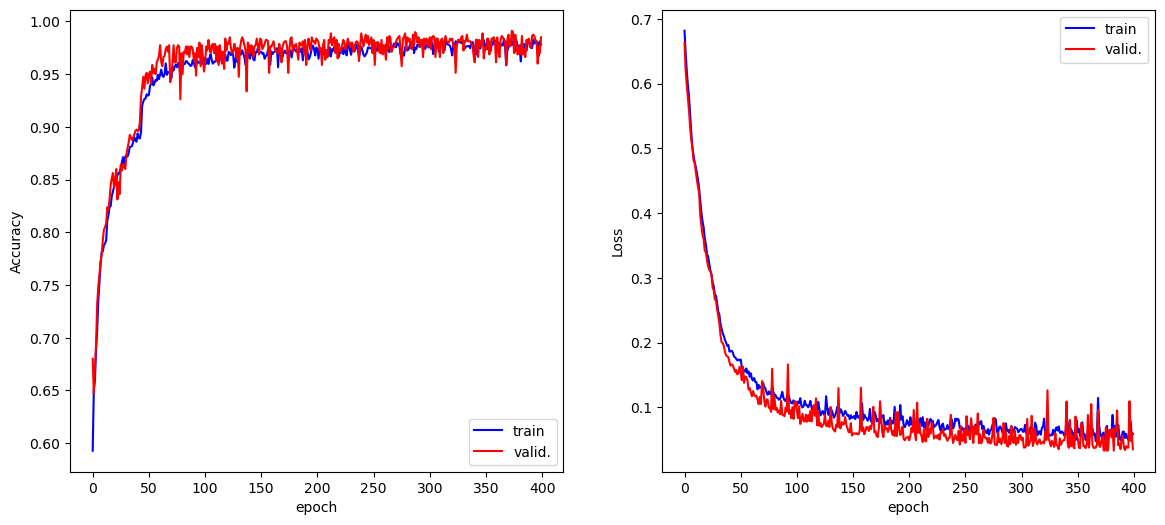

In [67]:
fig,AX=plt.subplots(1,2,figsize=(14,6.))
ax=AX[0]
ax.plot(history.history['accuracy'],label="train",c="b")
ax.plot(history.history['val_accuracy'],label="valid.",c="r")
ax.set_xlabel('epoch')
ax.set_ylabel("Accuracy")
ax.legend()
ax=AX[1]
ax.plot(history.history['loss'],label="train",c="b")
ax.plot(history.history['val_loss'],label="valid.",c="r")
ax.set_xlabel('epoch')
ax.set_ylabel("Loss")
ax.legend()

## EX.1 Modify the Hyperparameters to Optimize Performance of the Mode

In [31]:
from sklearn.model_selection import GridSearchCV
#from keras.wrappers.scikit_learn import KerasClassifier
from scikeras.wrappers import KerasClassifier

nepochs=10
batch_size=50

In [34]:
# list of allowed optional arguments for the optimizer, see `compile_model()`
optimizer = ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']
act_func = ['sigmoid', 'ReLU', 'ELU']

# call Keras scikit wrapper
model_gridsearch = KerasClassifier(model=compile_model, 
                        epochs=1, 
                        batch_size=batch_size, 
                        verbose=1,
                        act_func=act_func)

# define parameter dictionary
param_grid = dict(optimizer=optimizer, act_func=act_func)
print(param_grid)
# call scikit grid search module
grid = GridSearchCV(estimator=model_gridsearch, param_grid=param_grid, n_jobs=1, cv=4)
grid_result = grid.fit(x_train, y_train)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

{'optimizer': ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam'], 'act_func': ['sigmoid', 'ReLU', 'ELU']}
48/48 [==============================] - 2s 6ms/step - loss: 0.6687 - accuracy: 0.6000


64/64 [==============================] - 2s 6ms/step - loss: 0.6147 - accuracy: 0.6650
Best: 0.673437 using {'act_func': 'ELU', 'optimizer': 'RMSprop'}
0.508750 (0.015155) with: {'act_func': 'sigmoid', 'optimizer': 'SGD'}
0.508750 (0.015155) with: {'act_func': 'sigmoid', 'optimizer': 'RMSprop'}
0.508750 (0.015155) with: {'act_func': 'sigmoid', 'optimizer': 'Adagrad'}
0.508750 (0.015155) with: {'act_func': 'sigmoid', 'optimizer': 'Adadelta'}
0.508750 (0.015155) with: {'act_func': 'sigmoid', 'optimizer': 'Adam'}
0.508750 (0.015155) with: {'act_func': 'sigmoid', 'optimizer': 'Adamax'}
0.517500 (0.000000) with: {'act_func': 'sigmoid', 'optimizer': 'Nadam'}
0.656562 (0.025638) with: {'act_func': 'ReLU', 'optimizer': 'SGD'}
0.623750 (0.049883) with: {'act_func': 'ReLU', 'optimizer': 'RMSprop'}
0.650000 (0.020860) with: {'act_func': 'ReLU', 'optimizer': 'Adagrad'}
0.618125 (0.070636) with: {'act_func': 'ReLU', 'optimizer': 'Adadelta'}
0.669687 (0.054618) with: {'act_func': 'ReLU', 'optimizer'

## Ex.2 Change the number of sample 

### Reduced number of sample

In [48]:
print(grid_result.best_params_['optimizer'])

RMSprop


In [62]:
x = np.loadtxt(filename("data",TYPE), delimiter=' ')
y = np.loadtxt(filename("labels",TYPE), delimiter=' ')

red_val=0.6
(x, y) = (x[:int(red_val*len(x))], y[:int(red_val*len(x))])

N=len(x)
perc_train=0.8
N_train = int(N*perc_train)

(x_train, y_train) = (x[0:N_train],y[0:N_train]) #they are already shuffle 
(x_valid, y_valid) = (x[N_train:],y[N_train:])
print("Train:",len(x_train),"\t Validation:",len(x_valid))

Train: 1920 	 Validation: 480


In [63]:
#optimization
nepochs=400
batch_size=50

model_reduced = compile_model(optimizer=grid_result.best_params_['optimizer'], 
                              act_func=grid_result.best_params_['act_func'])

In [69]:
history_reduced = model_reduced.fit(x_train, y_train,
               epochs = nepochs, batch_size = batch_size,
               validation_data=(x_valid,y_valid),
               verbose=2)

Epoch 1/400
39/39 - 3s - loss: 0.6964 - accuracy: 0.5911 - val_loss: 0.5363 - val_accuracy: 0.7604 - 3s/epoch - 68ms/step
Epoch 2/400
39/39 - 0s - loss: 0.5548 - accuracy: 0.7359 - val_loss: 0.4985 - val_accuracy: 0.7771 - 329ms/epoch - 8ms/step
Epoch 3/400
39/39 - 0s - loss: 0.5214 - accuracy: 0.7458 - val_loss: 0.4826 - val_accuracy: 0.7792 - 325ms/epoch - 8ms/step
Epoch 4/400
39/39 - 0s - loss: 0.5074 - accuracy: 0.7568 - val_loss: 0.4857 - val_accuracy: 0.7937 - 314ms/epoch - 8ms/step
Epoch 5/400
39/39 - 0s - loss: 0.4952 - accuracy: 0.7667 - val_loss: 0.4568 - val_accuracy: 0.7937 - 369ms/epoch - 9ms/step
Epoch 6/400
39/39 - 0s - loss: 0.4855 - accuracy: 0.7688 - val_loss: 0.4554 - val_accuracy: 0.8042 - 355ms/epoch - 9ms/step
Epoch 7/400
39/39 - 0s - loss: 0.4791 - accuracy: 0.7792 - val_loss: 0.4410 - val_accuracy: 0.7979 - 368ms/epoch - 9ms/step
Epoch 8/400
39/39 - 0s - loss: 0.4681 - accuracy: 0.7760 - val_loss: 0.4384 - val_accuracy: 0.7958 - 350ms/epoch - 9ms/step
Epoch 9/40

Epoch 67/400
39/39 - 0s - loss: 0.3700 - accuracy: 0.8224 - val_loss: 0.3478 - val_accuracy: 0.8438 - 323ms/epoch - 8ms/step
Epoch 68/400
39/39 - 0s - loss: 0.3643 - accuracy: 0.8344 - val_loss: 0.3462 - val_accuracy: 0.8500 - 314ms/epoch - 8ms/step
Epoch 69/400
39/39 - 0s - loss: 0.3689 - accuracy: 0.8286 - val_loss: 0.3551 - val_accuracy: 0.8354 - 341ms/epoch - 9ms/step
Epoch 70/400
39/39 - 0s - loss: 0.3652 - accuracy: 0.8266 - val_loss: 0.3395 - val_accuracy: 0.8458 - 336ms/epoch - 9ms/step
Epoch 71/400
39/39 - 0s - loss: 0.3630 - accuracy: 0.8307 - val_loss: 0.3515 - val_accuracy: 0.8417 - 303ms/epoch - 8ms/step
Epoch 72/400
39/39 - 0s - loss: 0.3616 - accuracy: 0.8286 - val_loss: 0.3397 - val_accuracy: 0.8500 - 298ms/epoch - 8ms/step
Epoch 73/400
39/39 - 0s - loss: 0.3529 - accuracy: 0.8391 - val_loss: 0.3362 - val_accuracy: 0.8500 - 309ms/epoch - 8ms/step
Epoch 74/400
39/39 - 0s - loss: 0.3549 - accuracy: 0.8370 - val_loss: 0.3300 - val_accuracy: 0.8521 - 305ms/epoch - 8ms/step


Epoch 133/400
39/39 - 0s - loss: 0.2894 - accuracy: 0.8625 - val_loss: 0.2939 - val_accuracy: 0.8562 - 293ms/epoch - 8ms/step
Epoch 134/400
39/39 - 0s - loss: 0.2904 - accuracy: 0.8589 - val_loss: 0.2863 - val_accuracy: 0.8625 - 286ms/epoch - 7ms/step
Epoch 135/400
39/39 - 0s - loss: 0.2912 - accuracy: 0.8620 - val_loss: 0.2795 - val_accuracy: 0.8646 - 287ms/epoch - 7ms/step
Epoch 136/400
39/39 - 0s - loss: 0.2914 - accuracy: 0.8589 - val_loss: 0.2909 - val_accuracy: 0.8542 - 299ms/epoch - 8ms/step
Epoch 137/400
39/39 - 0s - loss: 0.2890 - accuracy: 0.8625 - val_loss: 0.2776 - val_accuracy: 0.8667 - 297ms/epoch - 8ms/step
Epoch 138/400
39/39 - 0s - loss: 0.2857 - accuracy: 0.8583 - val_loss: 0.2729 - val_accuracy: 0.8687 - 282ms/epoch - 7ms/step
Epoch 139/400
39/39 - 0s - loss: 0.2887 - accuracy: 0.8625 - val_loss: 0.2759 - val_accuracy: 0.8625 - 289ms/epoch - 7ms/step
Epoch 140/400
39/39 - 0s - loss: 0.2920 - accuracy: 0.8630 - val_loss: 0.2849 - val_accuracy: 0.8667 - 299ms/epoch - 8

39/39 - 0s - loss: 0.2833 - accuracy: 0.8609 - val_loss: 0.2649 - val_accuracy: 0.8708 - 309ms/epoch - 8ms/step
Epoch 199/400
39/39 - 0s - loss: 0.2838 - accuracy: 0.8656 - val_loss: 0.2811 - val_accuracy: 0.8667 - 292ms/epoch - 7ms/step
Epoch 200/400
39/39 - 0s - loss: 0.2814 - accuracy: 0.8609 - val_loss: 0.2670 - val_accuracy: 0.8708 - 325ms/epoch - 8ms/step
Epoch 201/400
39/39 - 0s - loss: 0.2793 - accuracy: 0.8682 - val_loss: 0.2921 - val_accuracy: 0.8625 - 365ms/epoch - 9ms/step
Epoch 202/400
39/39 - 0s - loss: 0.2837 - accuracy: 0.8635 - val_loss: 0.2788 - val_accuracy: 0.8667 - 337ms/epoch - 9ms/step
Epoch 203/400
39/39 - 0s - loss: 0.2860 - accuracy: 0.8604 - val_loss: 0.2798 - val_accuracy: 0.8646 - 425ms/epoch - 11ms/step
Epoch 204/400
39/39 - 0s - loss: 0.2852 - accuracy: 0.8651 - val_loss: 0.2736 - val_accuracy: 0.8687 - 386ms/epoch - 10ms/step
Epoch 205/400
39/39 - 0s - loss: 0.2854 - accuracy: 0.8620 - val_loss: 0.2698 - val_accuracy: 0.8750 - 403ms/epoch - 10ms/step
Epo

39/39 - 0s - loss: 0.2799 - accuracy: 0.8646 - val_loss: 0.2666 - val_accuracy: 0.8792 - 289ms/epoch - 7ms/step
Epoch 264/400
39/39 - 0s - loss: 0.2778 - accuracy: 0.8677 - val_loss: 0.2723 - val_accuracy: 0.8646 - 283ms/epoch - 7ms/step
Epoch 265/400
39/39 - 0s - loss: 0.2820 - accuracy: 0.8661 - val_loss: 0.2743 - val_accuracy: 0.8687 - 334ms/epoch - 9ms/step
Epoch 266/400
39/39 - 0s - loss: 0.2829 - accuracy: 0.8625 - val_loss: 0.2605 - val_accuracy: 0.8750 - 336ms/epoch - 9ms/step
Epoch 267/400
39/39 - 0s - loss: 0.2828 - accuracy: 0.8646 - val_loss: 0.2725 - val_accuracy: 0.8729 - 313ms/epoch - 8ms/step
Epoch 268/400
39/39 - 0s - loss: 0.2807 - accuracy: 0.8661 - val_loss: 0.2958 - val_accuracy: 0.8542 - 325ms/epoch - 8ms/step
Epoch 269/400
39/39 - 0s - loss: 0.2821 - accuracy: 0.8609 - val_loss: 0.2731 - val_accuracy: 0.8708 - 308ms/epoch - 8ms/step
Epoch 270/400
39/39 - 0s - loss: 0.2769 - accuracy: 0.8656 - val_loss: 0.2672 - val_accuracy: 0.8687 - 338ms/epoch - 9ms/step
Epoch 

39/39 - 0s - loss: 0.2757 - accuracy: 0.8677 - val_loss: 0.2775 - val_accuracy: 0.8583 - 354ms/epoch - 9ms/step
Epoch 329/400
39/39 - 0s - loss: 0.2731 - accuracy: 0.8719 - val_loss: 0.2684 - val_accuracy: 0.8750 - 324ms/epoch - 8ms/step
Epoch 330/400
39/39 - 0s - loss: 0.2769 - accuracy: 0.8672 - val_loss: 0.2748 - val_accuracy: 0.8646 - 314ms/epoch - 8ms/step
Epoch 331/400
39/39 - 0s - loss: 0.2759 - accuracy: 0.8682 - val_loss: 0.2614 - val_accuracy: 0.8792 - 366ms/epoch - 9ms/step
Epoch 332/400
39/39 - 0s - loss: 0.2758 - accuracy: 0.8656 - val_loss: 0.2642 - val_accuracy: 0.8750 - 347ms/epoch - 9ms/step
Epoch 333/400
39/39 - 0s - loss: 0.2741 - accuracy: 0.8708 - val_loss: 0.2597 - val_accuracy: 0.8792 - 316ms/epoch - 8ms/step
Epoch 334/400
39/39 - 0s - loss: 0.2790 - accuracy: 0.8635 - val_loss: 0.2631 - val_accuracy: 0.8750 - 331ms/epoch - 8ms/step
Epoch 335/400
39/39 - 0s - loss: 0.2767 - accuracy: 0.8651 - val_loss: 0.2674 - val_accuracy: 0.8687 - 305ms/epoch - 8ms/step
Epoch 

39/39 - 0s - loss: 0.2737 - accuracy: 0.8703 - val_loss: 0.2599 - val_accuracy: 0.8750 - 349ms/epoch - 9ms/step
Epoch 394/400
39/39 - 0s - loss: 0.2765 - accuracy: 0.8698 - val_loss: 0.2844 - val_accuracy: 0.8646 - 299ms/epoch - 8ms/step
Epoch 395/400
39/39 - 0s - loss: 0.2725 - accuracy: 0.8667 - val_loss: 0.2599 - val_accuracy: 0.8750 - 320ms/epoch - 8ms/step
Epoch 396/400
39/39 - 0s - loss: 0.2714 - accuracy: 0.8714 - val_loss: 0.2667 - val_accuracy: 0.8229 - 322ms/epoch - 8ms/step
Epoch 397/400
39/39 - 0s - loss: 0.2754 - accuracy: 0.8656 - val_loss: 0.2759 - val_accuracy: 0.8667 - 319ms/epoch - 8ms/step
Epoch 398/400
39/39 - 0s - loss: 0.2763 - accuracy: 0.8672 - val_loss: 0.2814 - val_accuracy: 0.8708 - 323ms/epoch - 8ms/step
Epoch 399/400
39/39 - 0s - loss: 0.2763 - accuracy: 0.8661 - val_loss: 0.2825 - val_accuracy: 0.8583 - 330ms/epoch - 8ms/step
Epoch 400/400
39/39 - 0s - loss: 0.2762 - accuracy: 0.8687 - val_loss: 0.2651 - val_accuracy: 0.8771 - 394ms/epoch - 10ms/step
